# How to use scranpy

## Load a dataset

for the notebook, we will use the zeisel dataset from [here](https://github.com/kanaverse/random-test-files/releases/tag/zeisel-brain-v1.0.0)

In [2]:
import anndata
data = anndata.read_h5ad("./csc.h5ad")
data

AnnData object with n_obs × n_vars = 3005 × 20006
    obs: 'tissue', 'group #', 'total mRNA mol', 'well', 'sex', 'age', 'diameter', 'cell_id', 'level1class', 'level2class'
    var: 'featureType'
    uns: 'X_name'

In [3]:
matrix = data.X.T
features = data.var.index.tolist()

## Run the analysis

In [4]:
import scranpy
results = scranpy.analyze(matrix, features)
# results

In [5]:
result_sce = results.to_sce(matrix)
print(result_sce)

Class SingleCellExperiment with 20006 features and 2874 cells 
  main_experiment_name: None 
  assays: ['counts', 'logcounts'] 
  features: [] 
  cell annotations: ['sums', 'detected', 'subset_proportions', 'size_factors', 'clusters'] 
  reduced dimensions: ['pca', 'tsne', 'umap'] 
  alternative experiments: None


## Plot the results

In [6]:
import biocborn as bb
import numpy as np

In [7]:
clusters = [f"cluster_{i}" for i in results.clusters]

### Embeddings

In [8]:
results.tsne

TsneEmbedding(x=array([ 4.99515934,  5.12158214,  4.20419511, ..., 20.78391851,
       18.13295117, 15.11904321]), y=array([-27.61260505, -27.1836627 , -27.69006661, ...,   6.62271717,
         2.9579    ,   6.41608151]))

In [9]:
tsne_ndarray = np.column_stack((results.tsne.x, results.tsne.y))
tsne_ndarray

array([[  4.99515934, -27.61260505],
       [  5.12158214, -27.1836627 ],
       [  4.20419511, -27.69006661],
       ...,
       [ 20.78391851,   6.62271717],
       [ 18.13295117,   2.9579    ],
       [ 15.11904321,   6.41608151]])

/opt/miniconda3/envs/biocpy39/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


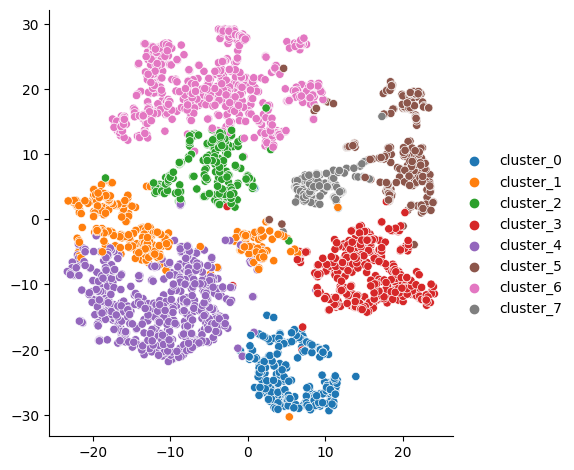

In [10]:
bb.plot_reduced_dim(tsne_ndarray, color_by=clusters)

/opt/miniconda3/envs/biocpy39/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


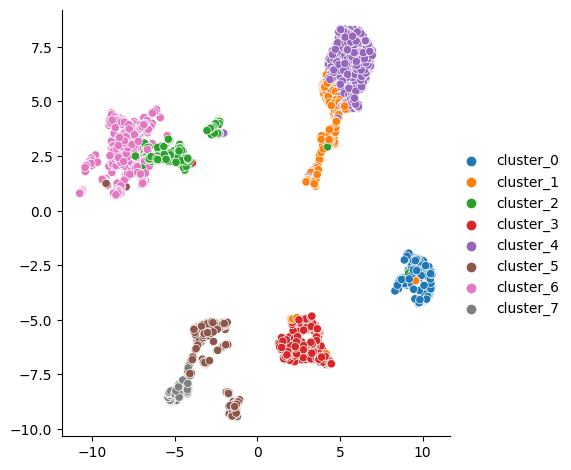

In [11]:
umap_ndarray = np.column_stack((results.umap.x, results.umap.y))
bb.plot_reduced_dim(umap_ndarray, color_by=clusters)

### Overlay the expression of a gene

In [12]:
# matrix[0,:].toarray()[0].tolist()
result_sce.assays["logcounts"]

<20006 x 2874> DelayedArray object of type 'float64'
[[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
  0.        ],
 [1.61193761, 0.7399364 , 0.        , ..., 0.        , 0.        ,
  0.        ],
 [1.61193761, 0.7399364 , 1.93394714, ..., 0.        , 0.        ,
  0.        ],
 ...,
 [6.77235238, 7.77777029, 6.63320662, ..., 2.79776017, 9.21275804,
  7.48397813],
 [4.47584682, 5.90614488, 5.54244482, ..., 0.        , 7.27109432,
  5.91504395],
 [3.30917964, 3.37593341, 2.38722125, ..., 2.79776017, 5.81367314,
  3.98504606]]

## KERNEL DIES

In [ ]:
# get the 1st row
import numpy as np

logc = np.array(result_sce.assays["logcounts"])
gene_1 = logc[1, :]
gene_1

In [ ]:
# direct access also crashes

gene_1 = result_sce.assays["logcounts"][1, :]
gene_1

In [ ]:
bb.plot_reduced_dim(tsne_ndarray, color_by = gene_1)